Are corporations price gouging grocery prices?

In [1]:
import pandas as pd
import numpy as np
import pprint
import json
import os
import glob
import requests
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)       

In [3]:
# Links 

# https://www.npr.org/2024/09/09/nx-s1-5103935/grocery-prices-inflation-corporate-greedflation
# https://www.foodandwaterwatch.org/2024/03/26/high-food-prices-consolidation/
# https://news.northeastern.edu/2024/08/29/why-are-food-prices-so-high-price-gouging/

In [4]:
api_key = open('/Users/admin/Desktop/api json practice/alpha vantage/api_key.txt').read().strip()

In [5]:
symbols = ['KR', 'ACI', 'WMT', 'COST'] # Kroger, Albertsons, General Mills, Walmart and Costco ticker symbols
sheets = ['INCOME_STATEMENT', 'BALANCE_SHEET', 'CASH_FLOW']
sheetsLower = list(x.lower() for x in sheets)

Retrieving data from Alpha Vantage API

In [6]:
# Creating a loop in loop to loop through the symbols and financial sheets
for symbol in symbols:
    for sheet in sheets:
        url = f'https://www.alphavantage.co/query?function={sheet}&symbol={symbol}&apikey={api_key}'
        r = requests.get(url)
        data = r.json()
        data = json.dumps(data)
        
        # Writing the info to a txt file because Alpha Vantage only allows 25 calls per day
        with open(f'{symbol.lower()}-{sheet.lower()}.txt', 'w') as file:
            file.write(data)

Looping over financial sheets to create 3 different dataframes, one per sheet

In [7]:
# Using the sheetsLower list, I create a dictionary that has the key and value for each financial sheet
dataframes = {sheet: pd.DataFrame() for sheet in sheetsLower}

# Creating a list of all the txt files so I can loop through them
txtList = glob.glob('*.txt')

for filename in txtList:
    # For statement to dictate what financial sheet to use depending on the keys in the dataframes dictionary
    for sheet_type in dataframes.keys():
        if filename.endswith(f'-{sheet_type}.txt'):
            with open(filename, 'r') as f:
                content = json.load(f)
            
            # Extracting the second value in the dictionary because that contains the relevant financial information
            second_value = list(content.values())[1]
            df = pd.DataFrame(second_value)
            
            # Getting the symbols name by splitting the filename
            symbol = filename.split('-')[0]
            
            df['symbol'] = symbol
            # Moving the symbol column so it's first
            df = df[['symbol'] + [col for col in df.columns if col != 'symbol']]
            
            # Appending the dataframe to its appropiate sheet type
            dataframes[sheet_type] = pd.concat([dataframes[sheet_type], df], ignore_index=True)
            

incomeDF = dataframes['income_statement']
balanceDF = dataframes['balance_sheet']
cashDF = dataframes['cash_flow']

listDF = [incomeDF, balanceDF, cashDF]

Cleaning dataframes

In [8]:
# Printing out a list of all columns because it's too long to view in a dataframe
incomeList = incomeDF.columns.to_list()
balanceList = balanceDF.columns.to_list()
cashList = cashDF.columns.to_list()
print(balanceList)

['symbol', 'fiscalDateEnding', 'reportedCurrency', 'totalAssets', 'totalCurrentAssets', 'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments', 'inventory', 'currentNetReceivables', 'totalNonCurrentAssets', 'propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'longTermInvestments', 'shortTermInvestments', 'otherCurrentAssets', 'otherNonCurrentAssets', 'totalLiabilities', 'totalCurrentLiabilities', 'currentAccountsPayable', 'deferredRevenue', 'currentDebt', 'shortTermDebt', 'totalNonCurrentLiabilities', 'capitalLeaseObligations', 'longTermDebt', 'currentLongTermDebt', 'longTermDebtNoncurrent', 'shortLongTermDebtTotal', 'otherCurrentLiabilities', 'otherNonCurrentLiabilities', 'totalShareholderEquity', 'treasuryStock', 'retainedEarnings', 'commonStock', 'commonStockSharesOutstanding']


In [9]:
def clean_df(df):
    # Getting the date to year
    df['fiscalDateEnding'] = pd.to_datetime(df['fiscalDateEnding'])
    df['fiscalDateEnding'] = df['fiscalDateEnding'].dt.year
    
    # Getting rid of all the white space in all rows so that I can switch datatypes without running into any issues
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.strip()
    
    # Replacing 'None' with nan values
    df = df.replace('None', 0)

    # Turning appropriate columns to float types
    df = df.set_index(['symbol', 'fiscalDateEnding'])
    df = df.apply(pd.to_numeric, errors='coerce')
    df.reset_index(inplace=True)
    
    # Dropping reportedCurrency column
    df.drop(columns= ['reportedCurrency'], inplace= True)
    
    return df

# Applying the cleaning function to all dataframes
listDF = [clean_df(df) for df in listDF]

# Reassigning the cleaned dataframes
incomeDF, balanceDF, cashDF = listDF

/var/folders/hk/jzskg0xs5pjggw047qcwrp980000gn/T/ipykernel_2130/1964033855.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('None', 0)
/var/folders/hk/jzskg0xs5pjggw047qcwrp980000gn/T/ipykernel_2130/1964033855.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('None', 0)


In [10]:
incomeList = incomeDF.columns.to_list()
balanceList = balanceDF.columns.to_list()
cashList = cashDF.columns.to_list()
print(incomeList)

['symbol', 'fiscalDateEnding', 'grossProfit', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'operatingExpenses', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda', 'netIncome']


Analysis and Visualizations

In [11]:
years = pd.Series(range(2015,2025))

incomeDF['grossMargin'] = ((incomeDF['totalRevenue'] - incomeDF['costofGoodsAndServicesSold']) / incomeDF['totalRevenue']) * 100

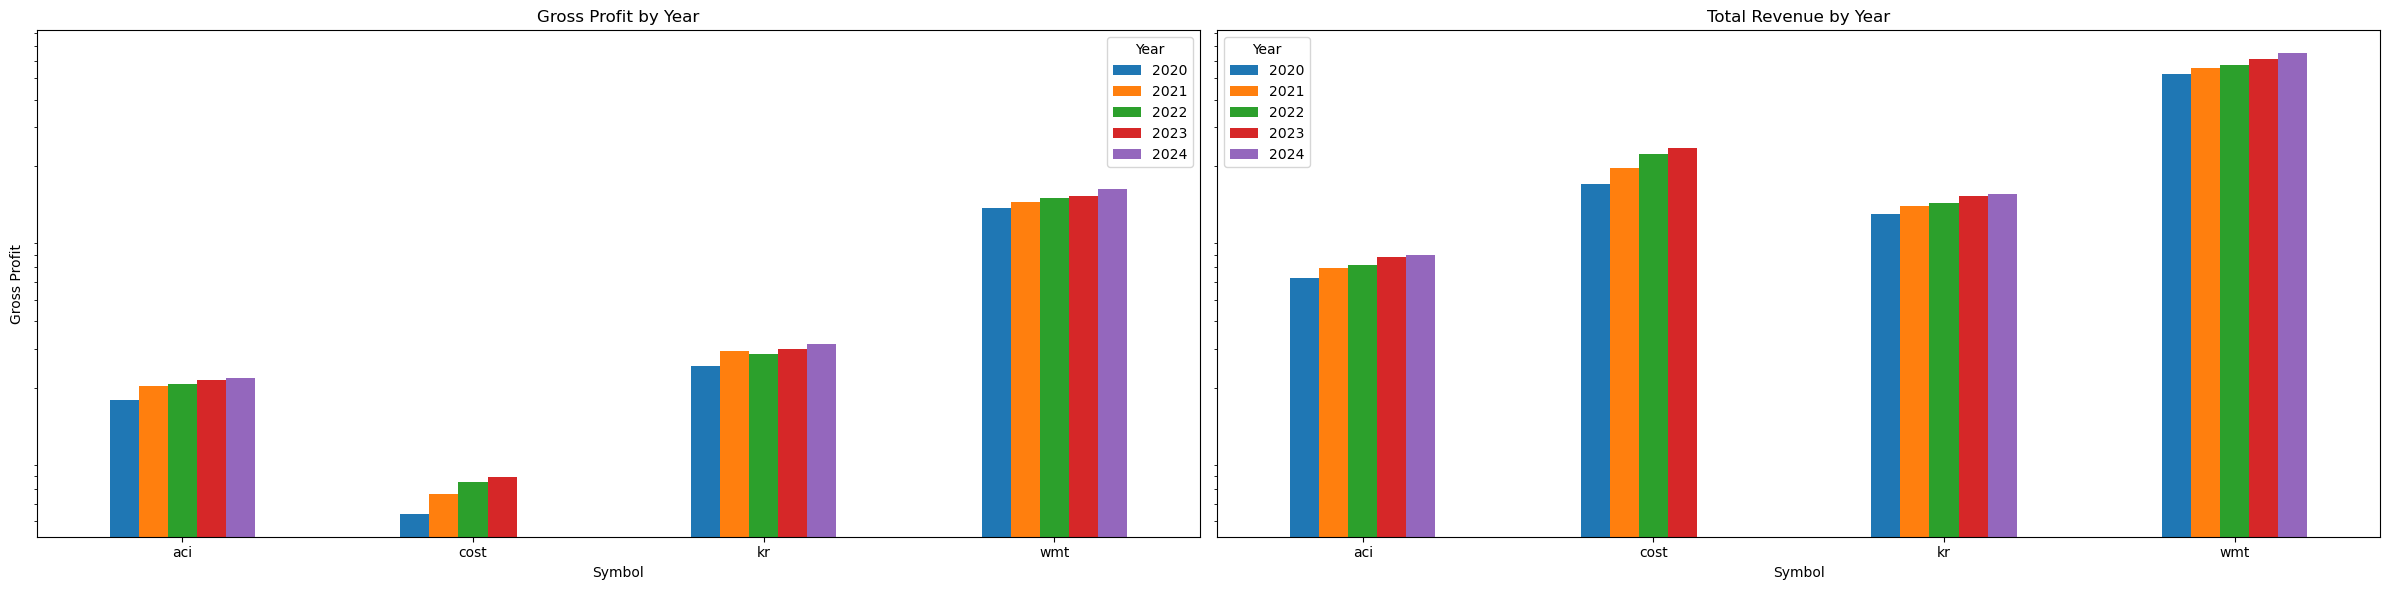

In [12]:
df = incomeDF[['symbol', 'fiscalDateEnding', 'grossProfit', 'totalRevenue']].query(' fiscalDateEnding >= 2020 ')
pivotProfit = df.pivot(index= 'symbol', columns= 'fiscalDateEnding', values= 'grossProfit')
pivotRev = df.pivot(index= 'symbol', columns= 'fiscalDateEnding', values= 'totalRevenue')

# Creating 2 subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharey=True)


# Gross Profit 
pivotProfit.plot.bar(ax=ax1, rot=0) # assining the graph it's specific subplot variable value
ax1.set_xlabel('Symbol')
ax1.set_ylabel('Gross Profit')
ax1.set_title('Gross Profit by Year')
ax1.legend(title='Year')
# Setting the y axis to log so that it's scaled correctly
ax1.set_yscale('log')
# Getting rid of ticks because we only need to see the visual growth and not the numerical value
ax1.set_yticks([])
ax1.set_yticklabels([])

# Total Revenue
pivotRev.plot.bar(ax=ax2, rot=0)
ax2.set_xlabel('Symbol')
ax2.set_ylabel('Total Revenue')
ax2.set_title('Total Revenue by Year')
ax2.legend(title='Year')
ax2.set_yscale('log')  
ax2.set_yticks([])
ax2.set_yticklabels([])

# Output
plt.tight_layout()
plt.show()

# Analysis
# Pictured below is the profit and revenue YoY for these retailers, as you can see, there is continuous growth since the pandemic (2020)

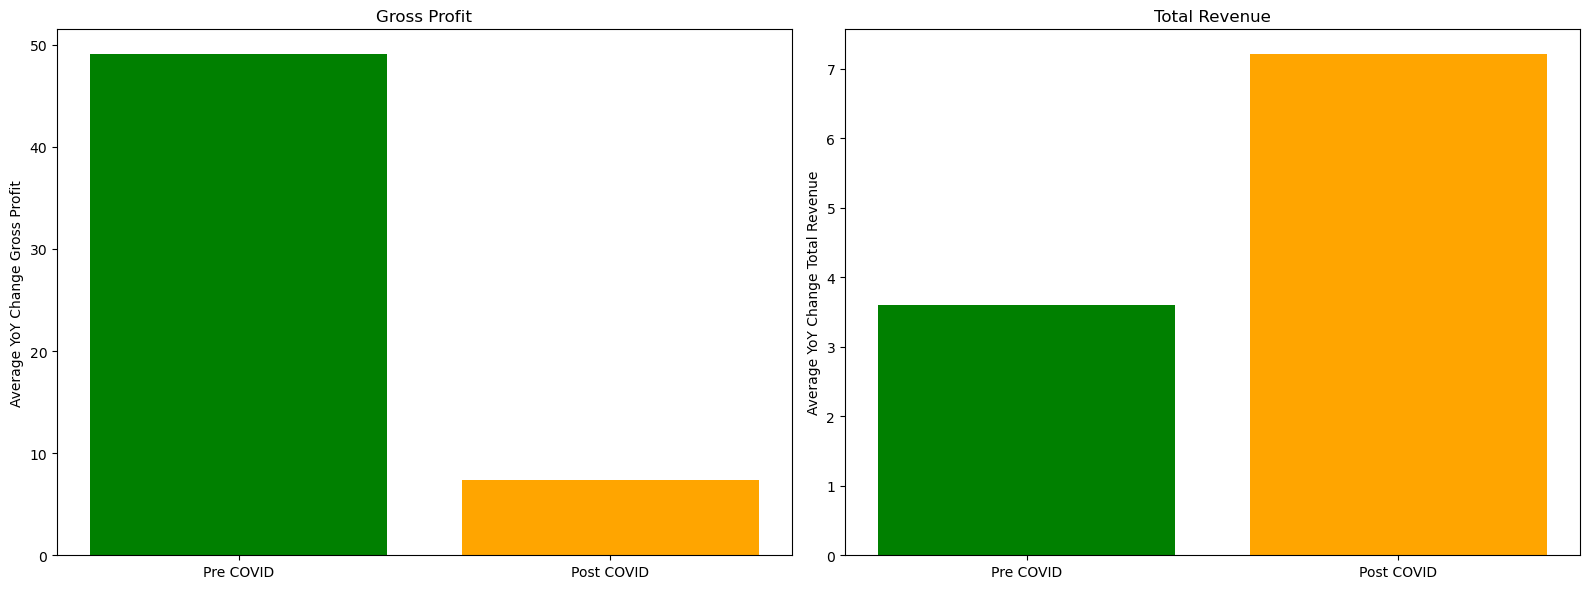

In [13]:
# Are companies seeing an increase in revenue and net profit since COVID?

grossDF = incomeDF[['symbol', 'fiscalDateEnding', 'grossProfit', 'totalRevenue']].query(' fiscalDateEnding in @years ').sort_values(by= ['symbol', 'fiscalDateEnding'], ascending= [True, True])
grossCOVID = grossDF.query(' fiscalDateEnding >= 2020 ')
grossPreCOVID = grossDF.query(' fiscalDateEnding < 2020 ').dropna()

grossCOVID = (grossCOVID.groupby(by= 'symbol')[['grossProfit', 'totalRevenue']].pct_change()) * 100
# grossCOVID = grossCOVID.add_suffix('PostCOVID')

grossPreCOVID = (grossPreCOVID.groupby(by= 'symbol')[['grossProfit', 'totalRevenue']].pct_change()) * 100

grossCOVID = pd.concat([grossDF[['symbol', 'fiscalDateEnding']], grossCOVID], axis=1).dropna()
grossPreCOVID = pd.concat([grossDF[['symbol', 'fiscalDateEnding']], grossPreCOVID], axis=1).dropna()

grossCOVID = grossCOVID[['grossProfit', 'totalRevenue']].mean()
grossPreCOVID = grossPreCOVID[['grossProfit', 'totalRevenue']].mean()

grossPreCOVID = grossPreCOVID.reset_index().T
grossPreCOVID.columns = grossPreCOVID.iloc[0]
grossPreCOVID = grossPreCOVID[1:]
grossPreCOVID['Pre / Post COVID'] = 'Pre COVID'
grossPreCOVID

grossCOVID = grossCOVID.reset_index().T
grossCOVID.columns = grossCOVID.iloc[0]
grossCOVID = grossCOVID[1:]
grossCOVID['Pre / Post COVID'] = 'Post COVID'
grossCOVID

grossDF = pd.concat([grossPreCOVID, grossCOVID], ignore_index= True)
grossDF



# Putting 2 graphs in one visual
fig, (bar1, bar2) = plt.subplots(1, 2, figsize=(16, 6))

# Gross Profit Graph
bar1.bar(grossDF['Pre / Post COVID'], grossDF['grossProfit'], color=['green', 'orange'])
bar1.set_ylabel('Average YoY Change Gross Profit')
bar1.set_title('Gross Profit')
bar1.set_xticks(grossDF['Pre / Post COVID'].unique())
bar1.set_xticklabels(grossDF['Pre / Post COVID'].unique(), rotation=0)

# Total Rev Graph
bar2.bar(grossDF['Pre / Post COVID'], grossDF['totalRevenue'], color=['green', 'orange'])
bar2.set_ylabel('Average YoY Change Total Revenue')
bar2.set_title('Total Revenue')
bar2.set_xticks(grossDF['Pre / Post COVID'].unique())
bar2.set_xticklabels(grossDF['Pre / Post COVID'].unique(), rotation=0)

plt.tight_layout()
plt.show()

# Analysis 
# While average YoY growth in gross profit is higher than pandemic levels for these companies, that growth is largely dominated by Costco and their monstruous 2019 profits.
# Looking average YoY growth in revenue, we're able to see that there is more growth post pandemic than before
# This builds up to the 'theory' that corporations are price gouging or implementing 'greed-flation'  

In [14]:
# Are companies seeing an increase in revenue / net profit / operating income since COVID?

grossDF = incomeDF[['symbol', 'fiscalDateEnding', 'grossProfit', 'totalRevenue', 'operatingIncome']].query(' fiscalDateEnding in @years ').sort_values(by= ['symbol', 'fiscalDateEnding'], ascending= [True, True])
grossPctDF = (grossDF.groupby(by= 'symbol')[['grossProfit', 'totalRevenue', 'operatingIncome']].pct_change()) * 100
grossPctDF = grossPctDF.add_suffix('yoy')
grossPctDF = pd.concat([grossDF[['symbol', 'fiscalDateEnding']], grossPctDF], axis=1)

grossPctCOVID = grossPctDF.query(' fiscalDateEnding >= 2020 ')
grossPct = grossPctDF.query(' fiscalDateEnding < 2020 ').dropna()

grossPctDF = grossPct.groupby(by= 'symbol').agg(
    {'grossProfityoy': 'mean',
     'totalRevenueyoy': 'mean',
     'operatingIncomeyoy': 'mean'
     })
grossPctDF = grossPctDF.reset_index()

grossPctCOVID = grossPctCOVID.groupby(by= 'symbol').agg(
    {'grossProfityoy': 'mean',
     'totalRevenueyoy': 'mean',
     'operatingIncomeyoy': 'mean'
     })
grossPctCOVID = grossPctCOVID.add_suffix('PostCOVID')
grossPctCOVID = grossPctCOVID.reset_index()

grossDF = grossPctDF.merge(grossPctCOVID, on= 'symbol')
grossDF

,symbol,grossProfityoy,totalRevenueyoy,operatingIncomeyoy,grossProfityoyPostCOVID,totalRevenueyoyPostCOVID,operatingIncomeyoyPostCOVID
0,aci,3.260783,1.017779,-1490.989399,5.599657,5.594178,26.019128
1,cost,72.444520,7.109163,6.998092,-6.336964,12.322285,14.612781
2,kr,84.405571,2.861394,-3.432612,4.923657,4.344889,5.677543
3,wmt,1.728975,1.459989,-4.888402,4.155371,4.752114,5.865620


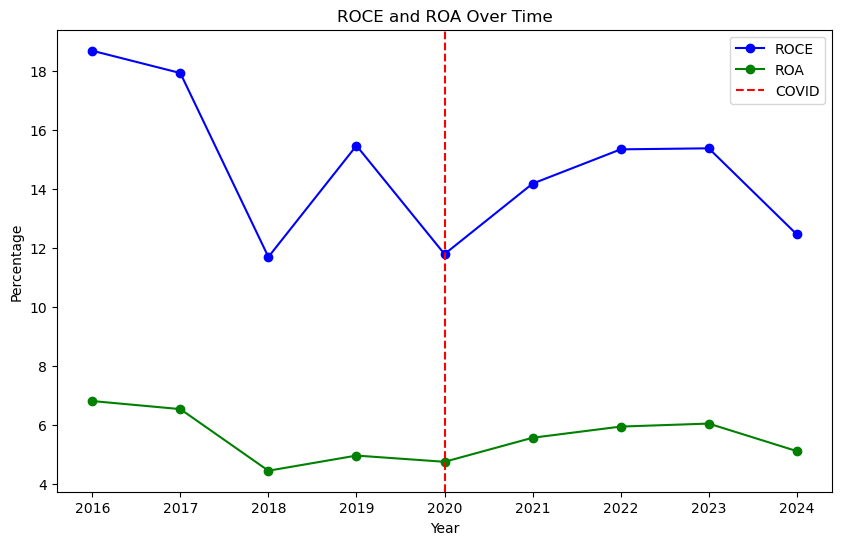

In [15]:
# Return on Capital Efficiency (ROCE) is a metric that tells you how efficient a company is at using its capital to generate income
# https://www.mosaic.tech/financial-metrics/capital-efficiency
# Return on Assets (ROA) is a metric that indicates a company's profitability relative to its total assets
# Both metrics are used to find how efficient a company is with its capital
# https://www.investopedia.com/terms/r/returnonassets.asp#:~:text=You%20can%20calculate%20a%20company


df = incomeDF.merge(balanceDF, on= ['symbol', 'fiscalDateEnding'])
df = df[['symbol', 'fiscalDateEnding', 'ebit', 'totalAssets', 'totalCurrentLiabilities', 'netIncome', 'operatingIncome', 'totalRevenue']]
df['ROCE'] = df['ebit'] / (df['totalAssets'] - df['totalCurrentLiabilities']) * 100
df['ROA'] = df['netIncome'] / df['totalAssets'] * 100
returnDF = df.groupby(by= 'fiscalDateEnding')[['ROCE', 'ROA']].mean()
returnDF = returnDF.reset_index()
returnDF.query(' fiscalDateEnding >= 2016 ', inplace= True)
returnDF


# Plotting the graph
plt.figure(figsize=(10, 6))

# ROCE line
plt.plot(returnDF['fiscalDateEnding'], returnDF['ROCE'], marker= 'o', label= 'ROCE', color= 'blue')

# ROA line 
plt.plot(returnDF['fiscalDateEnding'], returnDF['ROA'], marker= 'o', label= 'ROA', color= 'green')

plt.axvline(x=2020, color='red', linestyle='--', label='COVID')

plt.title('ROCE and ROA Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()

# No grid lines to reduce mental strain and focus on only the important aspects of the graph
plt.grid(False)

# Getting all years
plt.xticks(returnDF['fiscalDateEnding']) 

plt.show()


# Analysis
# There is no significant increase in ROA and ROCE post pandemic, however there were 3 years of growth before the dip in 2024 for both metrics
# Capital efficiency decreased in 2024, and while there was continuous growth in 2020 - 2023, neither metric has received it's high pre pandemic

/var/folders/hk/jzskg0xs5pjggw047qcwrp980000gn/T/ipykernel_2130/3765790966.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walGM['grossMargin'] = ((walGM['totalRevenue'] - (walGM['totalRevenue'] - walGM['grossProfit'])) / walGM['totalRevenue']) * 100


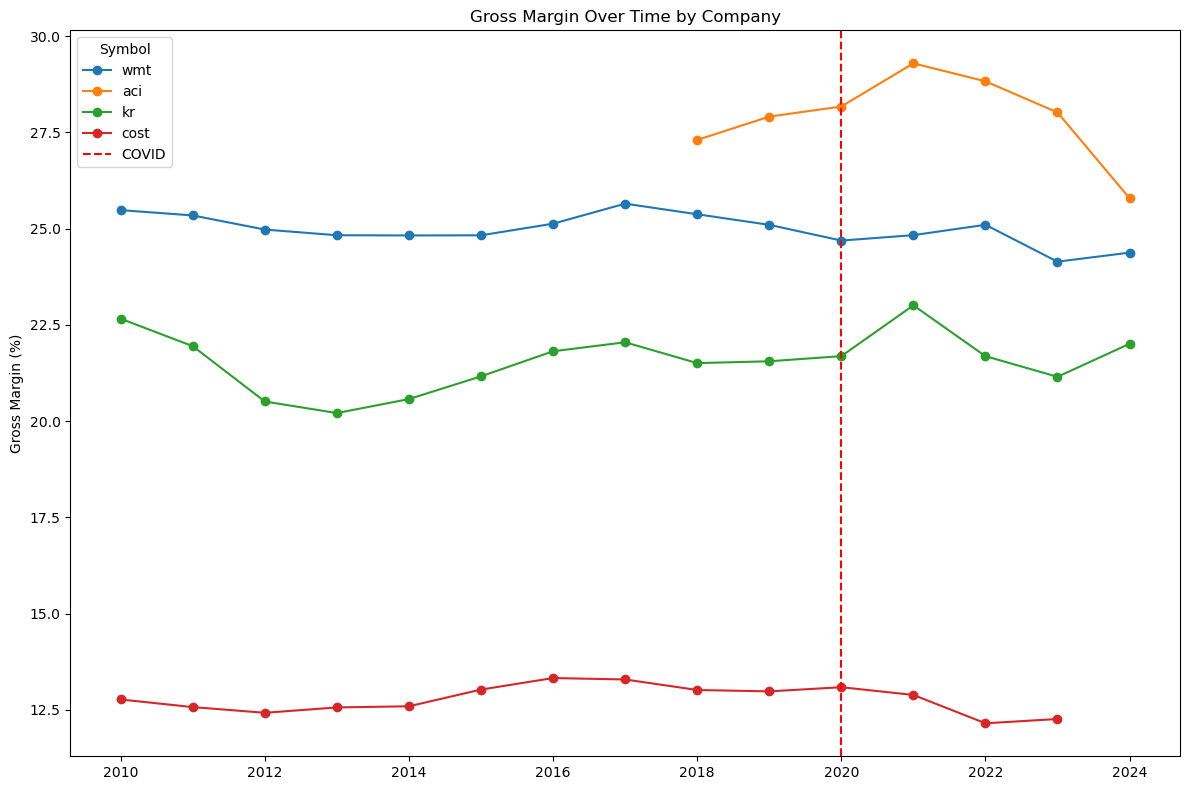

In [16]:
# Gross Margins is the percentage of how much a company makes after costs such as labor and materials have been accounted for. Basically how much more are they charging you

# Because Walmart cost of goods sold column was empty, I need to manually create the column, then find the gross margin afterwards
walGM = incomeDF.query(' symbol == "wmt" ')
walGM['grossMargin'] = ((walGM['totalRevenue'] - (walGM['totalRevenue'] - walGM['grossProfit'])) / walGM['totalRevenue']) * 100
walGM = walGM[['symbol', 'fiscalDateEnding', 'grossMargin']]

# Creating the dataframe with all the other symbols and their gross margin except for Walmart
allGM = incomeDF[['symbol', 'fiscalDateEnding', 'grossMargin']].query(' symbol != "wmt" ')

# Appending the 2 dataframes to graph together
finalGM = pd.concat([walGM, allGM], ignore_index= True)
finalGM


# Plotting the graph
plt.figure(figsize=(12, 8))

# Loop over each unique symbol
for symbol in finalGM['symbol'].unique():
    # Creating boolean mask to get the companies information based on the symbol
    company = finalGM[finalGM['symbol'] == symbol]
    
    # Plotting Gross Margin, one line for each symbol
    plt.plot(company['fiscalDateEnding'], company['grossMargin'], marker='o', label=symbol)

# Creating a line on 2020 to show the start of the pandemic
plt.axvline(x=2020, color='red', linestyle='--', label='COVID')

plt.ylabel('Gross Margin (%)')
plt.title('Gross Margin Over Time by Company')
plt.legend(title='Symbol')

plt.tight_layout()
plt.show()


# Analysis
# 3 out of the 4 companies has seen an increase in gross margin right after the pandemic but in later years, the number has decreased since
# ACI (Albertson's) and KR (Kroger) did see a bigger jump than the other companies but have fallen below that height in 2024

/var/folders/hk/jzskg0xs5pjggw047qcwrp980000gn/T/ipykernel_2130/2404411711.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omDF['operatingMargin'] = (omDF['operatingIncome'] / omDF['totalRevenue']) * 100


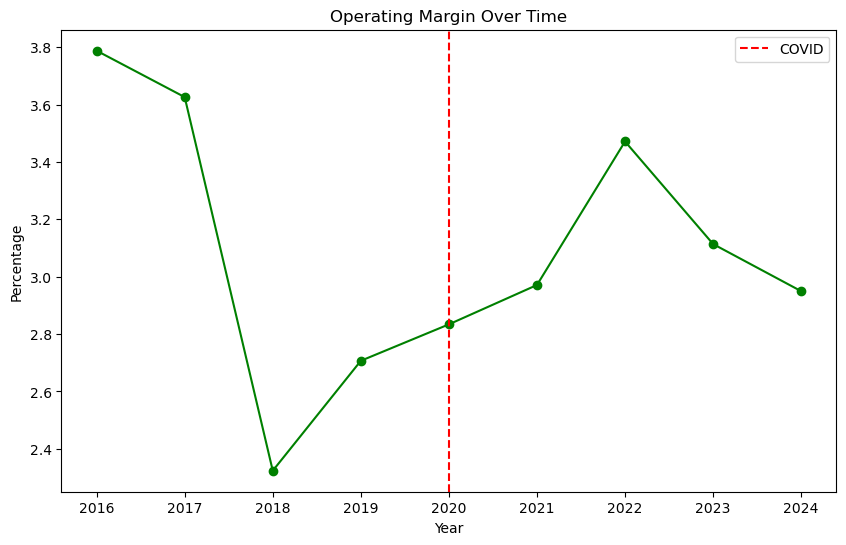

In [17]:
# Operaing Margins is how much a company makes on a dollar of sales after paying for variable costs of production such as wages and raw materials
# Basically how efficiently a company is able to make money through its core operations
# https://www.investopedia.com/terms/o/operatingmargin.asp


omDF = df[['symbol', 'fiscalDateEnding', 'operatingIncome', 'totalRevenue']]
omDF['operatingMargin'] = (omDF['operatingIncome'] / omDF['totalRevenue']) * 100
omDF = omDF.groupby(by= 'fiscalDateEnding')['operatingMargin'].mean()
omDF = omDF.reset_index().query(' fiscalDateEnding >= 2016 ')
omDF

# Plotting the graph
plt.figure(figsize=(10, 6))

# Operating Margin line
plt.plot(omDF['fiscalDateEnding'], omDF['operatingMargin'], marker= 'o', color= 'green')

# Creating a line on 2020 to show the start of the pandemic
plt.axvline(x=2020, color='red', linestyle='--', label='COVID')

# Adding titles and labels
plt.title('Operating Margin Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()

# No grid lines to reduce mental strain and focus on only the important aspects of the graph
plt.grid(False)

# Getting all years
plt.xticks(returnDF['fiscalDateEnding']) 

plt.show()

# Analysis
# Like other metrics, there is a sharp increase right after the pandemic, followed by a decrease 

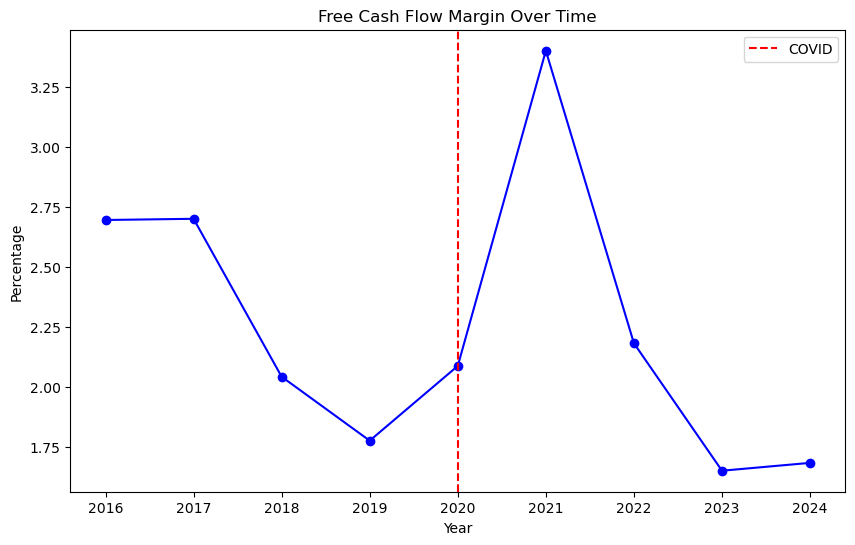

In [18]:
# Free cash flow margin is a metric that represents the cash a company generates after accounting for cash outflows to support its operations and maintain its capital assets
# https://www.wallstreetprep.com/knowledge/fcf-margin/

cashFlowDF = incomeDF.merge(cashDF, on= ['symbol', 'fiscalDateEnding'])
cashFlowDF = cashFlowDF[['symbol', 'fiscalDateEnding', 'operatingCashflow', 'totalRevenue', 'capitalExpenditures']]
cashFlowDF['fcfMargin'] = ((cashFlowDF['operatingCashflow'] - cashFlowDF['capitalExpenditures']) / cashFlowDF['totalRevenue']) * 100
cashFlowDF = cashFlowDF.groupby(by= 'fiscalDateEnding')['fcfMargin'].mean()
cashFlowDF = cashFlowDF.reset_index().query(' fiscalDateEnding >= 2016 ')
cashFlowDF


# Plotting the graph
plt.figure(figsize=(10, 6))

# Free cash flow margin line
plt.plot(cashFlowDF['fiscalDateEnding'], cashFlowDF['fcfMargin'], marker= 'o', color= 'blue')

# Creating a line on 2020 to show the start of the pandemic
plt.axvline(x=2020, color='red', linestyle='--', label='COVID')

# Adding titles and labels
plt.title('Free Cash Flow Margin Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()

# No grid lines to reduce mental strain and focus on only the important aspects of the graph
plt.grid(False)

# Getting all years
plt.xticks(cashFlowDF['fiscalDateEnding']) 

plt.show()


# Analysis
# Like other metrics, there is a sharp increase right after the pandemic, followed by a decrease 

In [ ]:
# Final Assessment

# From the financial statements, I don't believe there to be 'greed-flation' based on the metrics observed
# There is no consistent growth in: Free cash flow, Gross margins, ROCE / ROA, or Operating margin
# If the causes for increase in prices isn't internal than they must be external. 
# NY Fed believes the spike in prices is due to labor costs (increasing wages) and oil prices 
# https://www.marketwatch.com/story/heres-what-to-blame-for-the-spike-in-grocery-prices-according-to-a-new-york-fed-analysis-94da2c00